# Import the necessary libraries

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict as dd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (balanced_accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay, make_scorer)

# Load the dataset

In [3]:
df = pd.read_csv("music_preference.csv")
df.head(5)

,Unnamed: 0,Age,Gender,Music
0,0,32.0,Male,hip-pop
1,1,43.0,Female,NaN
2,2,24.0,Female,hip-pop
3,3,70.0,Male,country-side
4,4,32.0,Male,hip-pop


# Data Cleaning

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head(5)

,Age,Gender,Music
0,32.0,Male,hip-pop
1,43.0,Female,NaN
2,24.0,Female,hip-pop
3,70.0,Male,country-side
4,32.0,Male,hip-pop


In [5]:
no_of_data_samples_before = len(df)

In [6]:
df.isna().any()

Age        True
Gender    False
Music      True
dtype: bool

In [7]:
df.dropna(inplace=True, ignore_index=True)
df.head(5)

,Age,Gender,Music
0,32.0,Male,hip-pop
1,24.0,Female,hip-pop
2,70.0,Male,country-side
3,32.0,Male,hip-pop
4,74.0,Male,country-side


In [8]:
no_of_data_samples_after = len(df)

In [9]:
no_of_rows_dropped = no_of_data_samples_before - no_of_data_samples_after
print(no_of_rows_dropped)

17


In [10]:
print(df["Music"].value_counts())

Music
country-side    293
hip-pop         175
Name: count, dtype: int64


<IPython.core.display.Javascript object>


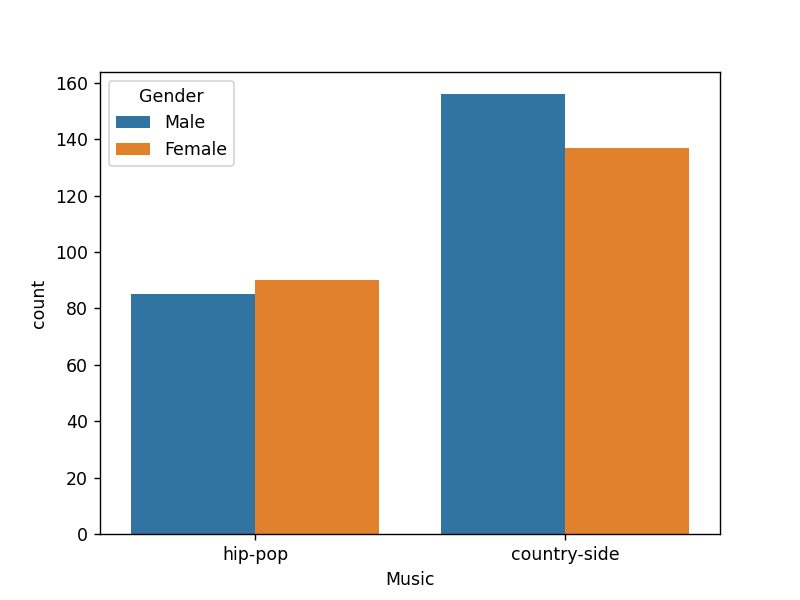

<Axes: xlabel='Music', ylabel='count'>

In [11]:
sns.countplot(df, x="Music", hue="Gender")

**It is obvious that the `country-side class` is about 1.7 times the `hip-pop class` indicating that our dataset is imbalanced. There are several ways of handling imbalanced datasets such as `oversampling` and `downsampling`. But we shall keep things simple here.**

In [12]:
df["Music"] = df["Music"].map({"hip-pop":0, "country-side":1})

In [13]:
le = LabelEncoder()

df["Gender"] = le.fit_transform(df["Gender"])
df.head(5)

,Age,Gender,Music
0,32.0,1,0
1,24.0,0,0
2,70.0,1,1
3,32.0,1,0
4,74.0,1,1


# Data Splitting

In [14]:
X = df.drop(columns='Music')
y = df['Music']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Hyperparameter optimization (Tuning)

In [16]:
parameters = [{"solver":("lbfgs", "liblinear"), "C":[0.1, 1]},
              {"n_neighbors":(5, 10), "weights":["uniform", "distance"]},
              {"n_estimators":(100, 200, 400), "ccp_alpha":(0.0, 1.0, 10), "criterion":["gini", "entropy", "log_loss"]},
              {'kernel':("linear", "rbf", "poly", "sigmoid"), 'C':[0.1, 1, 10]},
              {"var_smoothing":[1e-3, 1e-6, 1e-9]}, 
              {"ccp_alpha":(0.0, 1.0, 10.0), "criterion":["gini", "entropy", "log_loss"]}]

models = [["Logistic Regression", LogisticRegression()],
          ["KNN", KNeighborsClassifier()],
          ["Random Forest", RandomForestClassifier()],
          ["SVM", SVC(probability=True)],
          ["Gaussian NB", GaussianNB()],
          ["Decision Tree", DecisionTreeClassifier()]]

best_params = dd(list)

for (model_name, model), parameter in zip(models, parameters):
    clf = GridSearchCV(model, parameter)
    clf.fit(X_train, y_train)
    best_params[model_name].append(clf.best_params_)

In [17]:
print("The optimal parameter tuning for the models are:")
best_params

The optimal parameter tuning for the models are:


defaultdict(list,
            {'Logistic Regression': [{'C': 0.1, 'solver': 'lbfgs'}],
             'KNN': [{'n_neighbors': 5, 'weights': 'uniform'}],
             'Random Forest': [{'ccp_alpha': 0.0,
               'criterion': 'gini',
               'n_estimators': 400}],
             'SVM': [{'C': 0.1, 'kernel': 'linear'}],
             'Gaussian NB': [{'var_smoothing': 0.001}],
             'Decision Tree': [{'ccp_alpha': 0.0, 'criterion': 'gini'}]})

In [18]:
# parameters = [{"solver":('lbfgs', 'liblinear', "newton-cg", "newton-cholesky", "sag", "saga"), 
#                'C':[0.001, 0.1, 1, 10, 100]},
#               {"n_neighbors":(5, 10), "weights":["uniform", "distance"]},
#               {"n_estimators":(100, 200, 400, 500), "ccp_alpha":(0.0, 1.0, 10.0, 100.0), 
#                "criterion":["gini", "entropy", "log_loss"]},
#               {'kernel':("linear", "rbf", "poly", "sigmoid", "precomputed"), 'C':[0.001, 0.1, 1, 10, 100]},
#               {"var_smoothing":[1e-3, 1e-6, 1e-9, 1e-12, 1e-15]}, 
#               {"ccp_alpha":(0.0, 1.0, 10.0, 100.0), "criterion":["gini", "entropy", "log_loss"]}]

# models = [["Logistic Regression", LogisticRegression()],
#           ["KNN", KNeighborsClassifier()],
#           ["Random Forest", RandomForestClassifier()],
#           ["SVM", SVC(probability=True)],
#           ["Gaussian NB", GaussianNB()],
#           ["Decision Tree", DecisionTreeClassifier()]]

# best_params = dd(list)

# for (model_name, model), parameter in zip(models, parameters):
#     clf = GridSearchCV(model, parameter)
#     clf.fit(X_train, y_train)
#     best_params[model_name].append(clf.best_params_)

# 5-Fold Cross validation (Using the optimal parameter tunings)

In [25]:
models = [["Logistic Regression", LogisticRegression(C=0.1, solver="lbfgs")],
          ["KNN", KNeighborsClassifier(n_neighbors=5, weights="uniform")],
          ["Random Forest", RandomForestClassifier(ccp_alpha=0.0, criterion="gini", n_estimators=200)],
          ["SVM", SVC(C=0.1, kernel="linear")],
          ["Gaussian NB", GaussianNB(var_smoothing=0.001)],
          ["Decision Tree", DecisionTreeClassifier(ccp_alpha=0.0, criterion="gini")]]
        
# since Specificity is not explicitly defined in sklearn, we have to create it 
# from recall (sensitivity) using the make_scorer functions
specificity = make_scorer(recall_score, pos_label=0)

metrics = [["Accuracy", "balanced_accuracy"], ["F-Score", "f1"], ["Precision", "precision"], 
           ["Sensitivity", "recall"], ["Specificity", specificity], ["AUC", "roc_auc"]]

cv_scores = dd(list)
                    
for model_name, model in models:
    cv_scores["Classifier"].append(model_name)
    for metric_name, metric in metrics:  
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric)
        cv_scores[metric_name].append(scores.mean())
        
df_cv_scores = pd.DataFrame(cv_scores)
df_cv_scores.set_index('Classifier', inplace=True)
df_cv_scores.round(4)

,Accuracy,F-Score,Precision,Sensitivity,Specificity,AUC
Classifier,,,,,,
Logistic Regression,0.9700,0.9688,1.0000,0.9400,1.0000,0.9465
KNN,0.9829,0.9872,0.9878,0.9872,0.9786,0.9988
Random Forest,0.9821,0.9868,0.9918,0.9784,1.0000,0.9990
SVM,0.9700,0.9688,1.0000,0.9400,1.0000,0.9471
Gaussian NB,0.9700,0.9688,1.0000,0.9400,1.0000,0.9623
Decision Tree,0.9871,0.9868,1.0000,0.9742,1.0000,0.9990


**From the table above, all the models are perfect for the task. However, in terms of AUC and precision, Random Forest and Decision Tree are more favored**

# Performance on the test set

In [26]:
metrics = [["Accuracy", balanced_accuracy_score], 
           ["F-Score", f1_score], 
           ["Precision", precision_score], 
           ["Sensitivity", recall_score], 
           ["Specificity", recall_score],
           ["AUC", roc_auc_score]]
    
test_scores = dd(list)

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_scores["Classifier"].append(model_name)   
    for metric_name, metric in metrics:
        if metric_name == "Specificity":
            test_scores[metric_name].append(metric(y_test, y_pred, pos_label=0))
        else:
            test_scores[metric_name].append(metric(y_test, y_pred))
            
df_test_scores = pd.DataFrame(cv_scores)
df_test_scores.set_index('Classifier', inplace=True)
df_test_scores.round(4)

,Accuracy,F-Score,Precision,Sensitivity,Specificity,AUC
Classifier,,,,,,
Logistic Regression,0.9700,0.9688,1.0000,0.9400,1.0000,0.9465
KNN,0.9829,0.9872,0.9878,0.9872,0.9786,0.9988
Random Forest,0.9821,0.9868,0.9918,0.9784,1.0000,0.9990
SVM,0.9700,0.9688,1.0000,0.9400,1.0000,0.9471
Gaussian NB,0.9700,0.9688,1.0000,0.9400,1.0000,0.9623
Decision Tree,0.9871,0.9868,1.0000,0.9742,1.0000,0.9990


**Again, from the table above, all the models are perfect for the task. However, in terms of AUC and precision, Random Forest and Decision Tree are more favored**

# Confusion Matrix Display

<IPython.core.display.Javascript object>


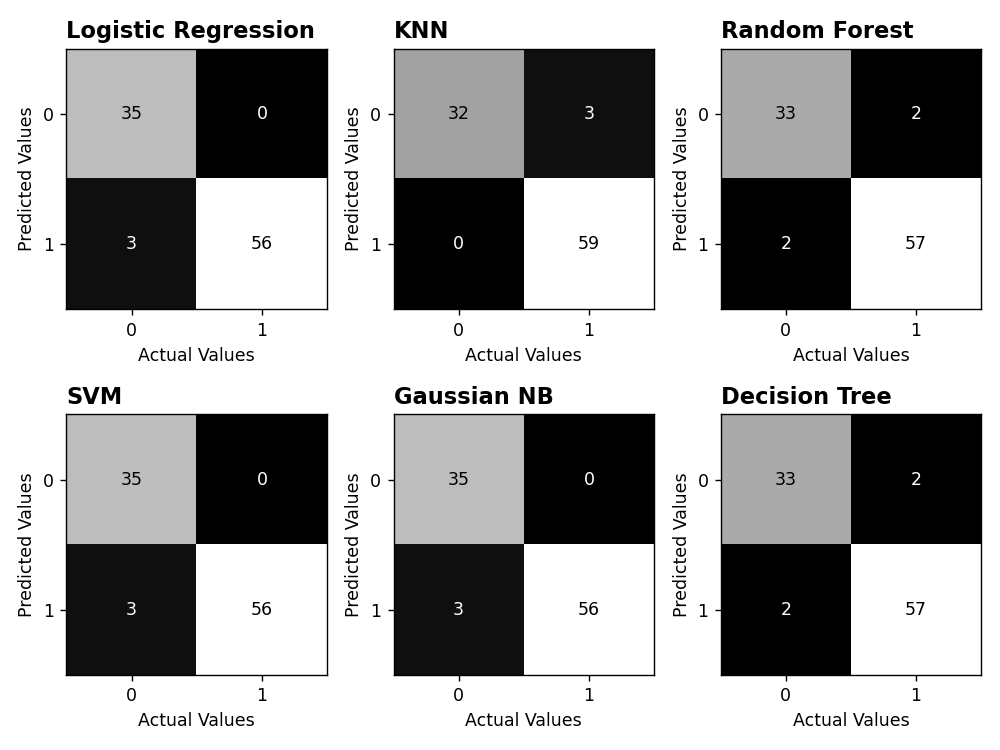

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for (model_name, model), ax, in zip(models, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap='Greys_r', colorbar=False)
    ax.set_title(label=model_name, loc="left", fontsize=13, fontweight="bold")
    ax.grid(False)
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
fig.tight_layout()
plt.show()

# AUC display

<IPython.core.display.Javascript object>


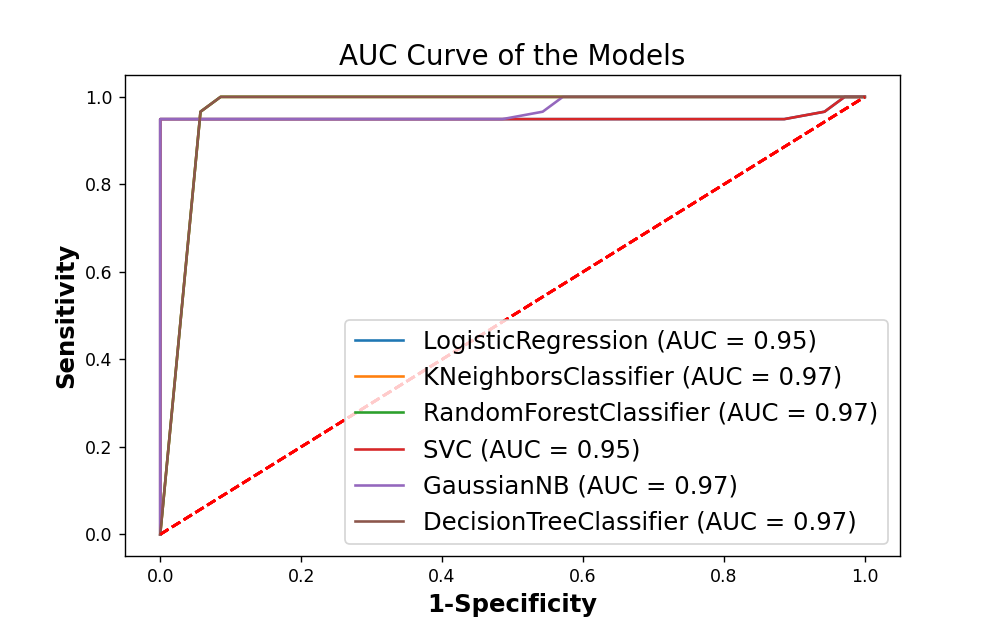

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,5])

for model_name, model in models:
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.set_title("AUC Curve of the Models", fontsize=16)
    ax.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
    ax.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
    ax.plot([0,1],[0,1], "r--") # adding a diagonal
    ax.legend(fontsize=14)
    ax.grid(False)

# Demonstrating `Pipelining` with Random Forest

In [30]:
rf = Pipeline([('scaler', StandardScaler()), ("Random Forest", RandomForestClassifier(ccp_alpha=0.0, criterion="gini", n_estimators=200))], 
              verbose=True)
rf.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Random Forest, total=   0.3s


Pipeline(steps=[('scaler', StandardScaler()),
                ('Random Forest', RandomForestClassifier(n_estimators=200))],
         verbose=True)

In [31]:
y_pred = rf.predict(X_test)
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {accuracy:.4f}")

The accuracy of the model is 0.9545
